<a href="https://colab.research.google.com/github/sangeethapk/AI-ML/blob/main/Assignment_7_NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


##2. Load Dataset

In [3]:
df = pd.read_csv("/content/judge-1377884607_tweet_product_company.csv", encoding='ISO-8859-1')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


We only need the tweet text and sentiment label.

In [4]:
df = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
df.columns = ['text', 'sentiment']
df.dropna(inplace=True)


##3. Clean Text Data

Remove URLs, mentions, hashtags, and special characters.

In [6]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = re.sub(r'@\w+', '', text)           # remove mentions
    text = re.sub(r'#\w+', '', text)           # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)    # remove non-alphabetic chars
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df.head()

,text,sentiment,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,i have a g iphone after hrs tweeting at it w...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know about awesome ipadiphone app that youll...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,can not wait for also they should sale them ...
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,i hope this years festival isnt as crashy as t...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff on fri marissa mayer google tim o...


##4. Encode Sentiment Labels

In [7]:
df['sentiment'] = df['sentiment'].replace({
    'Positive emotion': 'positive',
    'Negative emotion': 'negative',
    'No emotion toward brand or product': 'no_idea',
    'Neutral emotion': 'neutral'
})

le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])


In [8]:
df['sentiment'].value_counts()


,count
sentiment,
no_idea,5388
positive,2978
negative,570
I can't tell,156


##5. Train-Test Split


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])


##6. Tokenization & Padding

In [10]:
vocab_size = 20000
max_length = 40
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


##Step 7. Build the LSTM Model

In [20]:
from tensorflow.keras.layers import  Bidirectional
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##Step 8. Train the Model

In [21]:
history = model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.2,
    epochs=7,
    batch_size=64,
    verbose=1
)


Epoch 1/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 271ms/step - accuracy: 0.5419 - loss: 1.0793 - val_accuracy: 0.6158 - val_loss: 0.8435
Epoch 2/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - accuracy: 0.6679 - loss: 0.8422 - val_accuracy: 0.6591 - val_loss: 0.8136
Epoch 3/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - accuracy: 0.7553 - loss: 0.6669 - val_accuracy: 0.6687 - val_loss: 0.8003
Epoch 4/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.8131 - loss: 0.5289 - val_accuracy: 0.6495 - val_loss: 0.8755
Epoch 5/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.8578 - loss: 0.4126 - val_accuracy: 0.6680 - val_loss: 1.0741
Epoch 6/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.8798 - loss: 0.3540 - val_accuracy: 0.6488 - val_loss: 1.0701
Epoch 7/7
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8975 - loss: 0.2905 - val_accuracy: 0.6419 - val_loss: 1.0966


##Step 9. Evaluate on Test Data

In [23]:
loss, acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.6278


##Step 10. Visualize Training Progress

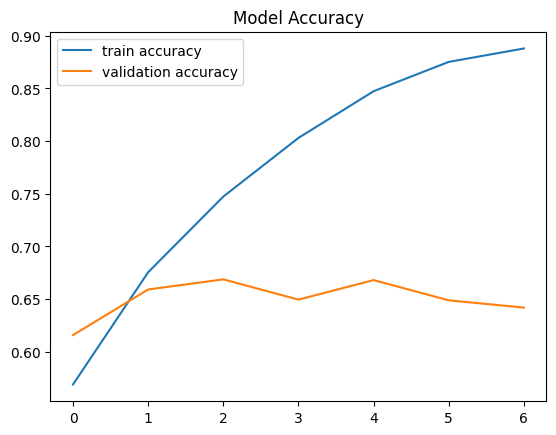

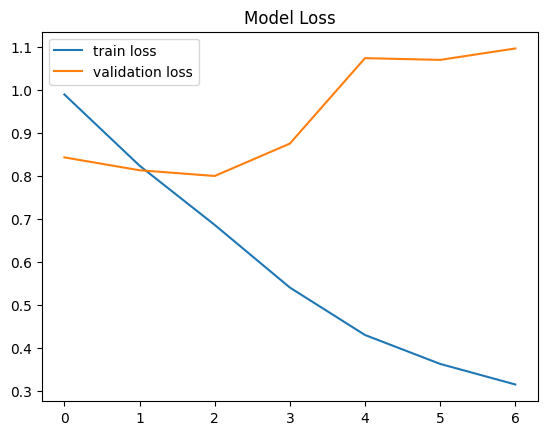

In [24]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Model Loss')
plt.show()


##Step 11. Make Predictions

In [25]:
def predict_sentiment(text):
    text_clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(pad)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

example = "I love my new iPhone, it's amazing!"
print(predict_sentiment(example))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
positive


In [38]:

print(predict_sentiment("The app keeps crashing every time I open it."))
print(predict_sentiment("Google's new feature is very useful!"))
print(predict_sentiment("The new Google update is a complete disaster."))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
no_idea
